# Weather Development on With Different Terains
Michael Wlochal, Mitchell Strimel, Zachary Pearlman
<br>
<br>

## Introduction

One of the most important coverages in society is the weather. It is the primary determinant in how a day is going to operate. If the weather is poor, entire cities can come to a halt. Therefore, it is essential to understand weather patterns and make predictions on what may occur next. The goal of this report is to explore the variable changes in weather patterns within different terains. To do so, an NetLogo agent-based model was created that tracks cloud coverage over a generic island. The island contains many of the common types of biomes across the world. To start the creationg of an overarcing weather prediction model, this model will provide general weather patterns, speciallizing in rainfall and cloudcover.
<br>

### Assumptions
- Extreme weather events will not be taken into account
- No other landmass outside of the island will affect the weather patterns
- Cloudcover greater that 20% will be tracked
- Natural jetstreams follow seasonal patterns
- Each timestep takes 0.5 hrs
- The cloud formation starts at 0 for each "sqaure" on the map
<br>

All of these assumptions create a natural and "unaltered" environment for the study of weather patterns on a gernalized island structure. Additionally, this allows for the natural course of weather to change with the season via the jetstream changes that occur. However, the main contraint is the lack of landmass aroundt he island. It is vital to creating a base model that is avoident of other land to reduce variability in the overall model. If other landedmasses had affect over the island, the cloud coverage over the terrain could not be properly studied as the other land would have major affect on the weather surrounding it.  

## Methods

This agents based weather model was built using NetLogo which modeled weather patterns of an island with varying landforms from planes to mountains to simulate real island geography. In order to asure a realistic model, many factors were taken into account such as the humidity, elevation, time of day, season, solar intensity, temperature, pressure, ocean and wind currents, and soil moisture to name a few. To begin, we'll start by defining the geography of the island in which the simulation will take place. To do this, we built rectangular regions with differing elevation regions to demonstrate the effect of elevation on cloud cover. Two examples of these rectangular regions are demonstrated below.



```nlogox
to setup-geography
  ask patches [
    set latitude 25 + (pycor + 40) * (25 / 80)
    set longitude -125 + (pxcor + 60) * (60 / 120)
    
    set water-body? true
    set elevation 0
    
    if pxcor >= -48 and pxcor <= 48 and pycor >= -35 and pycor <= 30 [
      set water-body? false
      set elevation 200 + random 300
    ] 
      
    if pxcor < -40 and pycor > 25 [
      set water-body? true
      set elevation 0
    ].... ; These are two examples of many chunks that built our islands geography
end
```

After our landmass was formed, the atmosphere in which the clouds would exist within needs to be defined next. The atmosphere has a few key factors that are focused on within this work, such as the humidity, pressures, and the wind. The cloud layers on initialization are all set to zero, and then throughout the first 100 ticks of the model, the world will set initialize itself for more consistant weather patterns.

```nlogox
to setup-atmosphere
  ask patches [
    ; Temperature decreases with latitude and elevation
    set temperature 25 - (latitude - 25) * 0.5 - (elevation / 150)
    
    ; Base pressure (decreases with elevation)
    set pressure 1013 - (elevation / 8.5)
    
    ifelse water-body? [
      set humidity 30 + random 15
      set soil-moisture 0
    ] [
      set humidity 15 + random 15
      set soil-moisture 50 + random 30  ; Initial soil moisture
    ]
    
    set wind-u 8 + random 12
    set wind-v (random-float 4) - 2
    
    ; Initialize all cloud layers to 0
  ]
end
```

Now that the atmosphere has been defined, now the weather can defined within our atmosphere. To define these weather systems. we need to know the jet strength and latitude. Within the to-setup-weather-systems. the initial date of March 21st, day 80, was selected due to this date being spring equinox, which allowed for easier initialization later on. The initial day/night cycle is defined.

```nlogox
to setup-weather-systems
  set current-jet-latitude initial-jet-latitude
  set current-jet-strength initial-jet-strength
  
  ; Initialize seasonal cycle (start in spring)
  set day-of-year 80  ; March 21 (spring equinox)
  set season "Spring"
  set solar-declination 0
  
  ; Initialize day/night cycle (start at dawn)
  set time-of-day 6
  set solar-intensity 0
```

As the weather systems are set up, many different factors will affect these weather systems, starting with the ocean currents with the code for how ocean currents are initialized is shown below.

```nlogox
; Initialize ocean currents and SST
  setup-ocean-currents
  
  repeat 2 + random 2 [
    let low-x -40 + random 70
    let low-y -25 + random 50
    ask patches with [distancexy low-x low-y < 12] [
      let dist distancexy low-x low-y
      set pressure pressure - (12 - dist) * 4
      if dist < 3 [
        set low-pressure-center? true
      ]
    ]
  ]
  
  repeat 2 + random 2 [
    let high-x -30 + random 60
    let high-y -20 + random 40
    ask patches with [distancexy high-x high-y < 15] [
      set pressure pressure + (15 - distancexy high-x high-y) * 3
    ]
  ]
end
```

As the earth rotates around the sun, seasons change and the sun changes its path across the sky. To implement this into the model, by tracking the days, we know what season it is within the model. The way that the sun's path is modified throughout the year is through solar declination, affecting how much sunlight and the amount of solar energy given from the sun onto this island. As the seasons change, the jet stream latitude also changes significantly, which effects the path of the clouds.

```nlogox
to update-seasonal-cycle
  ; Advance day (each tick = 0.5 hours, 48 ticks = 1 day)
  if ticks mod 48 = 0 [
    set day-of-year day-of-year + 1
    if day-of-year > 365 [
      set day-of-year 1
    ]
    
    ; Update season
    if day-of-year >= 1 and day-of-year < 80 [set season "Winter"]
    if day-of-year >= 80 and day-of-year < 172 [set season "Spring"]
    if day-of-year >= 172 and day-of-year < 266 [set season "Summer"]
    if day-of-year >= 266 and day-of-year < 356 [set season "Fall"]
    if day-of-year >= 356 [set season "Winter"]
  ]
  
  ; Calculate solar declination (sun's latitude)
  ; -23.5° at winter solstice (day 355), +23.5° at summer solstice (day 172)
  set solar-declination 23.5 * sin((day-of-year - 80) * 360 / 365)
  
  ; Adjust jet stream latitude by season
  ; Further north in summer, south in winter
  if season = "Summer" [
    set current-jet-latitude 50 + random 8
  ]
  if season = "Winter" [
    set current-jet-latitude 30 + random 8
  ]
  if season = "Spring" or season = "Fall" [
    set current-jet-latitude 40 + random 8
  ]
end
```

To move the clouds across the map, wind needs to be added to this model. Starting from our initial jet stream and jet latitude which is the basis of how the clouds will move. To change the paths of the wind, high and low pressure systems are developed, and then we take the pressure gradient to adjust pressure tendancies, and the convergance to update the wind.

```nlogox
to update-jet-stream
  set current-jet-latitude current-jet-latitude + (random-float 0.4) - 0.2
  
  if current-jet-latitude < 35 [set current-jet-latitude 35]
  if current-jet-latitude > 50 [set current-jet-latitude 50]
  
  ask patches [
    let distance-to-jet abs(latitude - current-jet-latitude)
    if distance-to-jet < 5 [
      set wind-u wind-u + (current-jet-strength * (5 - distance-to-jet) / 5) * 0.1
    ]
  ]
end

to update-pressure-systems
  ask patches [
    if pressure < 1000 or pressure > 1030 [
      let px-west nobody
      if pxcor > min-pxcor [
        set px-west patch-at -1 0
      ]
      
      if px-west != nobody [
        let pressure-anomaly pressure - 1013
        set pressure pressure - (pressure-anomaly * 0.05)
        ask px-west [
          set pressure pressure + (pressure-anomaly * 0.05)
        ]
      ]
    ]
    
    if pressure < 1015 [
      set pressure pressure + 0.1
    ]
    if pressure > 1015 [
      set pressure pressure - 0.1
    ]
  ]
  
  if ticks mod 100 = 0 and random-float 1.0 < 0.3 [
    let spawn-x -40 + random 30
    let spawn-y -20 + random 40
    ask patches with [distancexy spawn-x spawn-y < 10] [
      let dist distancexy spawn-x spawn-y
      set pressure pressure - (10 - dist) * 3
      if dist < 3 [
        set low-pressure-center? true
      ]
    ]
  ]
end

to calculate-pressure-gradient
  ask patches [
    let px-east ifelse-value (pxcor < max-pxcor) [[pressure] of patch-at 1 0] [pressure]
    let px-west ifelse-value (pxcor > min-pxcor) [[pressure] of patch-at -1 0] [pressure]
    let py-north ifelse-value (pycor < max-pycor) [[pressure] of patch-at 0 1] [pressure]
    let py-south ifelse-value (pycor > min-pycor) [[pressure] of patch-at 0 -1] [pressure]
    
    set pressure-tendency ((px-east - px-west) / 2) + ((py-north - py-south) / 2)
  ]
end

to calculate-convergence
  ask patches [
    let du-dx 0
    let dv-dy 0
    
    if pxcor < max-pxcor and pxcor > min-pxcor [
      let u-east [wind-u] of patch-at 1 0
      let u-west [wind-u] of patch-at -1 0
      set du-dx (u-east - u-west) / 2
    ]
    
    if pycor < max-pycor and pycor > min-pycor [
      let v-north [wind-v] of patch-at 0 1
      let v-south [wind-v] of patch-at 0 -1
      set dv-dy (v-north - v-south) / 2
    ]
    
    set vertical-velocity -1 * (du-dx + dv-dy)
    
    if vertical-velocity > 0.5 [
      set humidity min list 100 (humidity + vertical-velocity * 2)
    ]
  ]
end

to update-winds
  ask patches [
    let pgf-u (pressure-tendency / 10)
    let pgf-v (pressure-tendency / 10)
    
    let coriolis-param 0.02 * sin(latitude)
    let coriolis-u coriolis-param * wind-v * 0.75
    let coriolis-v -1 * coriolis-param * wind-u * 0.75
    
    set wind-u wind-u - pgf-u + coriolis-u
    set wind-v wind-v - pgf-v + coriolis-v
    
    if not water-body? [
      set wind-u wind-u * 0.9
      set wind-v wind-v * 0.9
    ]
    
    set wind-u wind-u + (random-float 0.6) - 0.2
    set wind-v wind-v + (random-float 0.6) - 0.2
    
    if wind-u > 40 [set wind-u 40]
    if wind-u < -40 [set wind-u -40]
    if wind-v > 30 [set wind-v 30]
    if wind-v < -30 [set wind-v -30]
  ]
end
```

To increase the humidity of the system again after the clouds have taken away the humidity, this work needs to account for evapotranspiration which varies evaporation with solar heating, cloud cover, and sea surface temperature.

```nlogox
to evapotranspiration
  ; Evaporation varies with solar heating, cloud cover, and SST
  ask patches [
    ; Calculate solar heating factor (reduced by clouds)
    let total-cloud-shading low-cloud-cover + mid-cloud-cover + high-cloud-cover
    let cloud-shading 1.0 - (total-cloud-shading / 250)  ; Can have up to 3 layers
    if cloud-shading < 0 [set cloud-shading 0]
    let local-solar moisture-flux  ; We stored it here
    let heating-factor local-solar * cloud-shading
    
    if water-body? and random-float 1.0 < 0.15 [
      ; Water evaporation - driven by SST (not air temp)
      let base-evap 0.01 + (sea-surface-temp / 650)
      let solar-boost base-evap * heating-factor * 5  ; Quadruple in full sun
      
      ; Warmer SST = much more evaporation (hurricane fuel!)
      if sea-surface-temp > 26 [
        set solar-boost solar-boost * (1 + (sea-surface-temp - 26) / 10)
      ]
      
      set humidity min list 100 (humidity + base-evap + solar-boost)
    ]
    
    if not water-body? and temperature > 10 and random-float 1.0 < 0.08 [
      ; Land transpiration - depends on soil moisture
      let moisture-factor soil-moisture / 100
      let base-evap (0.0075 + (temperature / 700)) * moisture-factor
      let solar-boost base-evap * heating-factor * 2
      
      set humidity min list 100 (humidity + base-evap + solar-boost)
      
      ; Deplete soil moisture
      set soil-moisture soil-moisture - (base-evap + solar-boost) * 2
      if soil-moisture < 0 [set soil-moisture 0]
    ]
  ]
end
```

Orographic lifting is a major factor in why mountain tops are extremely cloudy, since they push up air into the colder atmosphere above, which is more suitable for cloud formation. So this was included within our model as seen below.

```nlogox
to orographic-lifting
  ; Mountains force air upward, creating clouds
  ask patches with [elevation > 1500 and not water-body?] [
    ; Upwind side of mountains
    if wind-u > 5 [
      let lift-factor (elevation / 3000) * (wind-u / 20)
      
      ; Add moisture from lifting
      set humidity min list 100 (humidity + lift-factor * 3)
      
      ; Create orographic clouds if conditions are right
      if humidity > 70 and low-cloud-cover < 50 [
        let new-cloud-cover lift-factor * 15
        set low-cloud-cover min list 80 (low-cloud-cover + new-cloud-cover)
        set low-cloud-type "stratocumulus"
        
        ; Can produce light rain
        if low-cloud-cover > 65 and humidity > 80 [
          set precipitation precipitation + lift-factor * 0.5
        ]
      ]
    ]
  ]
end
```

Frontal systems are the boundaries between two air masses with different temperatures and densities which effect weather patterns and cloud movement. 

```nlogox
to frontal-systems
  ask patches with [not water-body?] [
    let temp-gradient 0
    
    if pxcor < max-pxcor [
      let neighbor-temp [temperature] of patch-at 1 0
      set temp-gradient abs(temperature - neighbor-temp)
    ]
    
    if temp-gradient > 5 [
      set humidity min list 100 (humidity + 5)
      set cloud-cover min list 100 (cloud-cover + 10)
      
      if temperature < 0 [
        set cloud-type "nimbostratus"
      ]
      if temperature >= 0 and temperature < 15 [
        set cloud-type "stratus"
      ]
    ]
  ]
end
```

To model the behavior of the clouds, the clouds need to be able to combine to form bigger systems which would then cause for those storm systems to rain. However if the cloud is too small or it's shrunk after it finishes raining, the clouds need to be able to naturally dissipate as well. This code block below also demostrates the logic for remoisturizing the soil by the rain, and how the clouds will move based upon the wind vector field that has been created.

```nlogox
to precipitation-process
  ; First, generate precipitation from raining clouds
  ask patches with [is-raining?] [
    set precipitation (low-cloud-cover - 60) / 5
    
    ; Heavy rain depletes cloud
    set low-cloud-cover low-cloud-cover - precipitation * 4
    set humidity min list 100 (humidity + precipitation * 1.5)
    set temperature temperature - (precipitation * 0.3)
    
    if low-cloud-cover < 20 [
      set is-raining? false
      set low-cloud-type "clear"
    ]
  ]
  
  ; NEW: Apply precipitation to ground (separate from cloud depletion)
  ask patches with [precipitation > 0.1] [
    if not water-body? [
      ; Rain recharges soil moisture on LAND
      set soil-moisture min list 100 (soil-moisture + precipitation * 3)
    ]
    
    ; Precipitation gradually decreases
    set precipitation precipitation * 0.7
    if precipitation < 0.1 [set precipitation 0]
  ]
end
to dissipation
  ask patches [
    ; LOW CLOUDS - Balanced dissipation
    if low-cloud-cover > 0 and not is-raining? [
      let cloudy-neighbors count neighbors with [low-cloud-cover > 25]
      let base-dissipation 3.5  ; More moderate
      
      ; Isolated clouds dissipate faster
      if cloudy-neighbors < 2 [
        set base-dissipation 10.0
      ]
      if cloudy-neighbors = 2 [
        set base-dissipation 7.0
      ]
      if cloudy-neighbors = 3 or cloudy-neighbors = 4 [
        set base-dissipation 5.0
      ]
      
      ; Dense cores persist
      if cloudy-neighbors >= 6 [
        set base-dissipation 1.0
      ]
      if cloudy-neighbors >= 7 [
        set base-dissipation 0.4
      ]
      
      ; High pressure dissipates clouds
      if pressure > 1018 [
        set base-dissipation base-dissipation + (pressure - 1018) / 2
      ]
      
      ; Low pressure preserves clouds
      if pressure < 1006 [
        set base-dissipation base-dissipation - (1006 - pressure) / 3
        if base-dissipation < 0.2 [set base-dissipation 0.2]
      ]
      
      ; Over water dissipates faster (but not as extreme)
      ifelse water-body? [
        set low-cloud-cover low-cloud-cover - (base-dissipation + 6.0)
      ] [
        set low-cloud-cover low-cloud-cover - base-dissipation
      ]
      
      ; Dry air kills clouds
      if humidity < 25 [
        set low-cloud-cover low-cloud-cover - 5.0
      ]
      
      if low-cloud-cover < 0 [set low-cloud-cover 0]
    ]
    
    ; MID CLOUDS
    if mid-cloud-cover > 0 [
      set mid-cloud-cover mid-cloud-cover - 1.5
      if humidity < 45 [
        set mid-cloud-cover mid-cloud-cover - 2.0
      ]
      if mid-cloud-cover < 0 [set mid-cloud-cover 0]
    ]
    
    ; HIGH CLOUDS
    if high-cloud-cover > 0 [
      set high-cloud-cover high-cloud-cover - 1.0
      if high-cloud-cover < 0 [set high-cloud-cover 0]
    ]
    
    ; Clear rain status if no clouds
    if low-cloud-cover = 0 [
      set is-raining? false
      set low-cloud-type "clear"
    ]
  ]
end

to move-clouds-with-wind
  ; Move ALL clouds together based on average wind (faster movement)
  let cloudy-patches patches with [low-cloud-cover > 20]  ; Changed threshold
  
  if any? cloudy-patches [
    let avg-wind-u mean [wind-u] of cloudy-patches
    let avg-wind-v mean [wind-v] of cloudy-patches
    
    ; Calculate movement - FASTER
    let shift-x round(avg-wind-u / 4)  ; Was /6, now /4 for faster movement
    let shift-y round(avg-wind-v / 4)  ; Was /10, now /8
    
    ; Move every tick if wind is strong enough
    if abs shift-x >= 1 or abs shift-y >= 1 [
      ; Store all cloud data
      let cloud-data []
      ask cloudy-patches [
        set cloud-data lput (list pxcor pycor low-cloud-cover mid-cloud-cover high-cloud-cover low-cloud-type mid-cloud-type high-cloud-type is-raining?) cloud-data
      ]
      
      ; Clear all clouds
      ask cloudy-patches [
        set low-cloud-cover 0
        set mid-cloud-cover 0
        set high-cloud-cover 0
        set low-cloud-type "clear"
        set mid-cloud-type "clear"
        set high-cloud-type "clear"
        set is-raining? false
      ]
      
      ; Place clouds at new positions
      foreach cloud-data [ cloud-info ->
        let old-x item 0 cloud-info
        let old-y item 1 cloud-info
        let lcc item 2 cloud-info
        let mcc item 3 cloud-info
        let hcc item 4 cloud-info
        let lct item 5 cloud-info
        let mct item 6 cloud-info
        let hct item 7 cloud-info
        let ir item 8 cloud-info
        
        let new-x old-x + shift-x
        let new-y old-y + shift-y
        
        ; Place at new location if in bounds
        if new-x >= min-pxcor and new-x <= max-pxcor and
          new-y >= min-pycor and new-y <= max-pycor [
          ask patch new-x new-y [
            if lcc > low-cloud-cover [
              set low-cloud-cover lcc
              set mid-cloud-cover mcc
              set high-cloud-cover hcc
              set low-cloud-type lct
              set mid-cloud-type mct
              set high-cloud-type hct
              set is-raining? ir
            ]
          ]
        ]
      ]
    ]
  ]
end
```

## Results


In [1]:
using Pkg
Pkg.add("DataFrames")
Pkg.add("CSV")
using DataFrames
using CSV

    Updating registry at `C:\Users\zpear\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\zpear\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\zpear\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
    Updating `C:\Users\zpear\.julia\environments\v1.11\Project.toml`
  [336ed68f] + CSV v0.10.15
  No Changes to `C:\Users\zpear\.julia\environments\v1.11\Manifest.toml`


In [ ]:
# Load all CSV files from a directory into a multiple DataFrames
function load_csv_files_to_dataframes(directory::String)
    dataframes = Dict{String, DataFrame}()
    for file in readdir(directory)
        if endswith(file, ".csv")
            file_path = joinpath(directory, file)
            df = CSV.read(file_path, DataFrame)
            dataframes[file] = df
        end
    end
    return dataframes
end

dataframes_dict = load_csv_files_to_dataframes("Data")

Dict{String, DataFrame} with 3 entries:
  "all_rainfall_runs.csv"      => 17520×21 DataFrame…
  "all_cloud_cover_runs.csv"   => 17520×21 DataFrame…
  "all_sample_pixels_runs.csv" => 17520×81 DataFrame…

In [12]:
rainfall_df = dataframes_dict["all_rainfall_runs.csv"]
cloud_cover_df = dataframes_dict["all_cloud_cover_runs.csv"]
first(rainfall_df, 5)

Row,tick,run_1,run_2,run_3,run_4,run_5,run_6,run_7,run_8,run_9,run_10,run_11,run_12,run_13,run_14,run_15,run_16,run_17,run_18,run_19,run_20
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0.0,0.0,0.0,0.0,0.000284915,0.0,0.000498736,0.000380744,0.0,0.0,0.000448352,0.0,0.0,0.0,0.0,0.000373628,0.000264471,0.0,0.0,0.00130923
4,3,0.00192972,0.00186598,0.00108183,0.000758955,0.00103075,0.000247418,0.00221218,0.001966,0.00100675,0.00141798,0.0026683,0.00156273,0.0013251,0.00261923,0.00226187,0.000969659,0.00479437,0.00128592,0.000832991,0.00242867
5,4,0.00634167,0.00532303,0.0027558,0.00285736,0.0038969,0.00292839,0.00573545,0.0022039,0.00259945,0.00358474,0.00758725,0.00575753,0.00553458,0.00822529,0.00668465,0.00438513,0.0078801,0.00497678,0.0045495,0.00412891


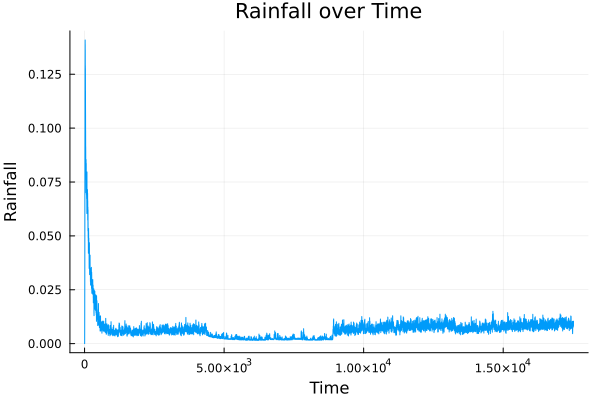

In [18]:
# Create graph visualizations
using Plots
#Create array of ticks for x-axis
ticks = 1:nrow(rainfall_df)
# Create array of rainfall values for y-axis
rainfall_values = rainfall_df.run_1
# Plot the rainfall data
plot(ticks, rainfall_values, xlabel="Time", ylabel="Rainfall", title="Rainfall over Time", legend=false)


## Conclusion